In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

path = '/kaggle/input/tabular-playground-series-jan-2022/'
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jan-2022/train.csv
/kaggle/input/tabular-playground-series-jan-2022/test.csv


In [2]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import dateutil.easter as easter
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt

In [3]:
gdp_df = pd.DataFrame([[234.440, 385.802, 505.104], [240.608, 368.827, 515.655], [255.017, 398.394, 541.019], [275.580, 437.000, 555.455], [268.782, 405.510, 533.880]], 
                   index=[2015, 2016, 2017, 2018, 2019], columns=['Finland', 'Norway', 'Sweden'])

In [4]:
train_data = pd.read_csv(path + 'train.csv', index_col=0, parse_dates=['date'])
test_data = pd.read_csv(path + 'test.csv', index_col=0, parse_dates=['date'])

In [5]:
gdp_merge = gdp_df.reset_index().melt(id_vars=['index'])
gdp_merge.columns = ['year', 'country', 'gdp']

In [6]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=np.concatenate([train_data.date.unique(), test_data.date.unique()]),
    constant=False,               # dummy feature for bias (y-intercept)
    order=0,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

In [7]:
def feature_engineering(train_data, train=True):
    data = train_data.copy(deep=True)
    if train:
        # sales log transformation
        data['num_sold'] = np.log(data['num_sold'])
        y = data['num_sold']

    # get year feature
    data['year'] = data.date.dt.year 
    
    # get gdp feature
    data = data.merge(gdp_merge, on=['year', 'country']) 
    data['gdp'] = np.log(data.gdp)
        
    # get country feature
    data['Finland'] = (data.country == 'Finland')
    data['Norway'] = (data.country == 'Norway')

    # get store feature
    data['KaggleRama'] = (data.store == 'KaggleRama')

    # get product feature
    data['Kaggle Mug'] = (data['product'] == 'Kaggle Mug')
    data['Kaggle Hat'] = (data['product'] == 'Kaggle Hat')

    X = dp.in_sample() 
    X_mug = X.copy(deep=True) # * np.array(data['Kaggle Mug']).reshape(-1, 1)
    X_mug.columns = ['mug_' + col for col in X.columns]
    X_hat = X.copy(deep=True) # * np.array(data['Kaggle Hat']).reshape(-1, 1)
    X_hat.columns = ['hat_' + col for col in X.columns]
    
    data = data.merge(X, left_on='date', right_index=True)
    data = data.merge(X_mug, left_on='date', right_index=True)
    data[X_mug.columns] = data[X_mug.columns] * np.array(data['Kaggle Mug']).reshape(-1, 1)
    data = data.merge(X_hat, left_on='date', right_index=True)
    data[X_hat.columns] = data[X_hat.columns] * np.array(data['Kaggle Hat']).reshape(-1, 1)
    
    # December feature
    for d in range(24, 32):
        data[f"dec{d}"] = (data.date.dt.month == 12) & (data.date.dt.day == d)
        data[f"Norway_dec{d}"] = (data.date.dt.month == 12) & (data.date.dt.day == d) & (data.country == 'Norway')
    for d in list(range(6, 14)):
        data[f"Finland_dec{d}"] = (data.date.dt.month == 12) & (data.date.dt.day == d) & (data.country == 'Finland')

    # Jan feature
    for d in range(1, 14):
        data[f"Finland_jan{d}"] = (data.date.dt.month == 1) & (data.date.dt.day == d) & (data.country == 'Finland')

    for d in range(1, 10):
        data[f"Norway_jan{d}"] = (data.date.dt.month == 1) & (data.date.dt.day == d) & (data.country == 'Norway')

    for d in range(1, 15):
        data[f"Sweden_jan{d}"] = (data.date.dt.month == 1) & (data.date.dt.day == d) & (data.country == 'Sweden')

    # May feature
    for d in list(range(1, 10)):
        data[f"may{d}"] = (data.date.dt.month == 5) & (data.date.dt.day == d) 
    for d in list(range(19, 26)):
        data[f"Norway_may{d}"] = (data.date.dt.month == 5) & (data.date.dt.day == d) & (data.country == 'Norway')

    # June feature
    for d in range(8, 14):
        data[f"Sweden_Jun{d}"] = (data.date.dt.month == 6) & (data.date.dt.day == d) & (data.country == 'Sweden')

    # Special June days
    jun_base = pd.Series([pd.Timestamp(('2015-06-24')), pd.Timestamp(('2016-06-29')), 
                          pd.Timestamp(('2017-06-28')), pd.Timestamp(('2018-06-27')), pd.Timestamp(('2019-06-26'))])
    for d in range(-4, 6):
        data[f'Norway_Jun_wed{d}'] = (data.date.isin(jun_base + pd.DateOffset(d))) & (data.country == 'Norway')

    # First Sunday of November
    nov_base = pd.Series([pd.Timestamp(('2015-11-1')), pd.Timestamp(('2016-11-6')),
                          pd.Timestamp(('2017-11-5')), pd.Timestamp(('2018-11-4')),pd.Timestamp(('2019-11-3'))])
    for d in range(0, 9):
        data[f'Norway_Nov_sun{d}'] = (data.date.isin(jun_base + pd.DateOffset(d))) & (data.country == 'Norway')

    # Easter
    easters = pd.Series([pd.Timestamp(easter.easter(year)) for year in range(2015, 2020)])
    for d in list(range(-2, 11)):
        data[f'easter{d}'] = (data.date.isin(easters + pd.DateOffset(d)))
    
    data['const'] = 1
    if train:
        X = data.drop(columns=['date', 'country', 'store', 'product', 'num_sold', 'year'])
#         y = data['num_sold']
        groups = data.year
        return X, y, groups
    
    else:
        return data.drop(columns=['date', 'country', 'store', 'product', 'year'])

In [8]:
X, y, groups = feature_engineering(train_data)

# Feature Selection via Lasso

In [9]:
best_alpha=1e-6
model = Lasso()
parameters = {'alpha': np.logspace(-8, 0, 16)}

In [10]:
gs = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', verbose=3)
gs.fit(X, y, groups=groups)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] alpha=1e-08 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................ alpha=1e-08, score=-0.004, total=   5.7s
[CV] alpha=1e-08 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV] ........................ alpha=1e-08, score=-0.004, total=   5.9s
[CV] alpha=1e-08 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s


[CV] ........................ alpha=1e-08, score=-0.003, total=   5.8s
[CV] alpha=1e-08 .....................................................
[CV] ........................ alpha=1e-08, score=-0.004, total=   6.5s
[CV] alpha=1e-08 .....................................................
[CV] ........................ alpha=1e-08, score=-0.004, total=   5.4s
[CV] alpha=3.4145488738336004e-08 ....................................
[CV] ....... alpha=3.4145488738336004e-08, score=-0.004, total=   5.5s
[CV] alpha=3.4145488738336004e-08 ....................................
[CV] ....... alpha=3.4145488738336004e-08, score=-0.004, total=   5.8s
[CV] alpha=3.4145488738336004e-08 ....................................
[CV] ....... alpha=3.4145488738336004e-08, score=-0.003, total=   5.5s
[CV] alpha=3.4145488738336004e-08 ....................................
[CV] ....... alpha=3.4145488738336004e-08, score=-0.004, total=   5.5s
[CV] alpha=3.4145488738336004e-08 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  4.2min finished


GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-08, 3.41454887e-08, 1.16591440e-07, 3.98107171e-07,
       1.35935639e-06, 4.64158883e-06, 1.58489319e-05, 5.41169527e-05,
       1.84784980e-04, 6.30957344e-04, 2.15443469e-03, 7.35642254e-03,
       2.51188643e-02, 8.57695899e-02, 2.92864456e-01, 1.00000000e+00])},
             scoring='neg_mean_squared_error', verbose=3)

In [11]:
gs.best_estimator_

Lasso(alpha=3.981071705534969e-07)

In [12]:
def smape_loss(y_true, y_pred, exp=False):
    """SMAPE Loss"""
    if exp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200

In [13]:
select_model = Lasso(alpha=4e-7, max_iter=4000)
select_model.fit(X, y)

Lasso(alpha=4e-07, max_iter=4000)

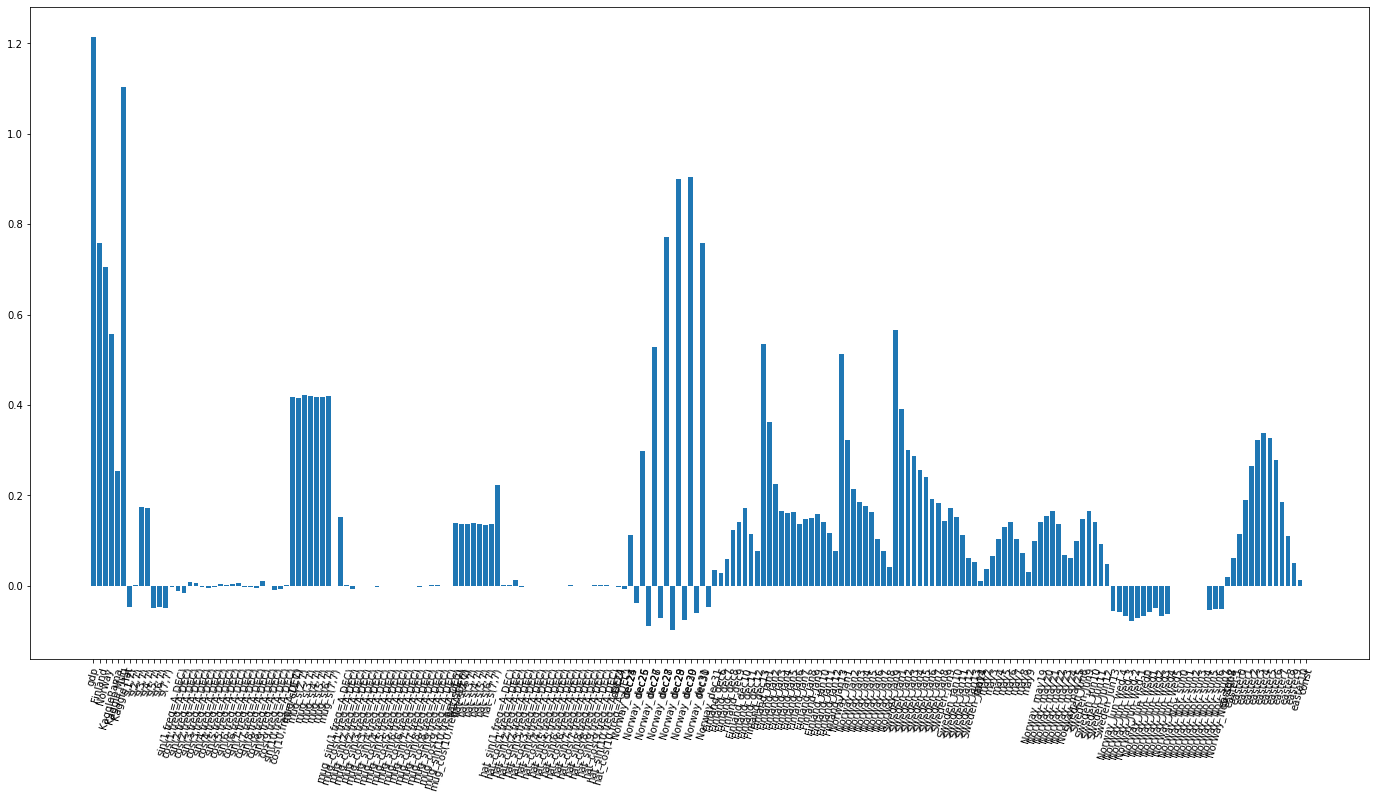

In [14]:
plt.figure(figsize=(24, 12))
plt.bar(X.columns, select_model.coef_)
plt.xticks(rotation=75)
plt.show()

In [15]:
good_cols = X.columns[np.abs(select_model.coef_) > 1e-6]

# Ridge Regression with Cross Validation

In [16]:
model = make_pipeline(MinMaxScaler(), Ridge())
parameters = {'ridge__alpha': np.logspace(-8, -2, 16)}

In [17]:
gs = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', verbose=3)
gs.fit(X[good_cols], y, groups=groups)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] ridge__alpha=1e-08 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. ridge__alpha=1e-08, score=-0.004, total=   1.6s
[CV] ridge__alpha=1e-08 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ................. ridge__alpha=1e-08, score=-0.004, total=   1.6s
[CV] ridge__alpha=1e-08 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV] ................. ridge__alpha=1e-08, score=-0.003, total=   1.7s
[CV] ridge__alpha=1e-08 ..............................................
[CV] ................. ridge__alpha=1e-08, score=-0.004, total=   1.6s
[CV] ridge__alpha=1e-08 ..............................................
[CV] ................. ridge__alpha=1e-08, score=-0.004, total=   1.7s
[CV] ridge__alpha=2.511886431509582e-08 ..............................
[CV] . ridge__alpha=2.511886431509582e-08, score=-0.004, total=   1.6s
[CV] ridge__alpha=2.511886431509582e-08 ..............................
[CV] . ridge__alpha=2.511886431509582e-08, score=-0.004, total=   1.6s
[CV] ridge__alpha=2.511886431509582e-08 ..............................
[CV] . ridge__alpha=2.511886431509582e-08, score=-0.003, total=   1.6s
[CV] ridge__alpha=2.511886431509582e-08 ..............................
[CV] . ridge__alpha=2.511886431509582e-08, score=-0.004, total=   1.6s
[CV] ridge__alpha=2.511886431509582e-08 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  2.1min finished


GridSearchCV(estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.00000000e-08, 2.51188643e-08, 6.30957344e-08, 1.58489319e-07,
       3.98107171e-07, 1.00000000e-06, 2.51188643e-06, 6.30957344e-06,
       1.58489319e-05, 3.98107171e-05, 1.00000000e-04, 2.51188643e-04,
       6.30957344e-04, 1.58489319e-03, 3.98107171e-03, 1.00000000e-02])},
             scoring='neg_mean_squared_error', verbose=3)

In [18]:
print(f'best score: {-gs.best_score_}')
print(f'best estimator: {gs.best_estimator_}')

best score: 0.003910762503352294
best estimator: Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('ridge', Ridge(alpha=0.01))])


In [19]:
rmodel = make_pipeline(MinMaxScaler(), Ridge(alpha=0.01))
rmodel.fit(X[good_cols], y)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('ridge', Ridge(alpha=0.01))])

In [20]:
X_test = feature_engineering(test_data, train=False)
y_pred = rmodel.predict(X_test[good_cols].astype(float))

# Use xgboost to fit the residual

In [21]:
residual = y - rmodel.predict(X[good_cols])

In [22]:
from xgboost import XGBRegressor

param_xgb = {
    'objective' : 'reg:squarederror',
    'tree_method' : 'hist',
    'learning_rate': 0.12,
    'max_depth': 5,
    'n_estimators': 240,
 }

xgbmodel = XGBRegressor(**param_xgb)

In [23]:
xgbmodel.fit(X[good_cols], residual)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.12, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=240, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='hist',
             validate_parameters=1, verbosity=None)

In [24]:
y_pred = rmodel.predict(X_test[good_cols]) + xgbmodel.predict(X_test[good_cols])

# Submission

In [25]:
sub = test_data.reset_index()[['row_id']].copy()
sub['num_sold'] = np.exp(y_pred).round()
sub.to_csv('submission.csv', index=False)